In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import zipfile
import pathlib
import sklearn
import torchvision
import torch
import torch.nn.functional as F
import numpy as np
from torch import nn, optim
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from types import SimpleNamespace
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
import cv2
from tqdm import tqdm
import gc
%matplotlib inline

In [3]:
zipFile = zipfile.ZipFile('/content/drive/MyDrive/Datasets/Cats_vs_Dogs.zip', 'r')
zipFile.extractall('Cats_vs_dogs')
zipFile.close()

#Assets

In [4]:
def get_mean_and_std(data_loader):
  mean = 0
  std = 0
  images_count = 0
  for images, _ in data_loader:
    
    images_in_the_batch = images.size(0)
    images = images.view(images_in_the_batch, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    images_count += images_in_the_batch
  
  mean /= images_count
  std /= images_count
  
  return mean, std

In [5]:
def check_accuracy(
    loader, model, loss_fn, input_shape=None, toggle_eval=True, print_accuracy=True
):
    """
    Check accuracy of model on data from loader
    """
    if toggle_eval:
        model.eval()
    device = next(model.parameters()).device
    num_correct = 0
    num_samples = 0

    y_preds = []
    y_true = []

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)
            if input_shape:
                x = x.reshape(x.shape[0], *input_shape)
            scores = model(x)
            predictions = torch.sigmoid(scores) > 0.5
            y_preds.append(torch.clip(torch.sigmoid(scores), 0.005, 0.995).cpu().numpy())
            y_true.append(y.cpu().numpy())
            num_correct += (predictions.squeeze(1) == y).sum()
            num_samples += predictions.size(0)

    accuracy = num_correct / num_samples

    if toggle_eval:
        model.train()

    if print_accuracy:
        print(f"Accuracy: {accuracy * 100:.2f}%")
        print(log_loss(np.concatenate(y_true, axis=0), np.concatenate(y_preds, axis=0)))

    return accuracy

In [26]:
def get_feature_vectors_for_resnet34(model, loader, device, output_size=(1, 1)):
    model.eval()
    images, labels = [], []

    for idx, (x, y) in enumerate(tqdm(loader)):
        x = x.to(device)

        with torch.no_grad():
            features = model(x)

        images.append(features.reshape(x.shape[0], -1).detach().cpu().numpy())
        labels.append(y.numpy())

    return np.concatenate(images, axis=0), np.concatenate(labels, axis=0)
    model.train()

In [25]:
def get_feature_vectors_for_resnet(model, loader, device, output_size=(1, 1)):
    model.eval()
    images, labels = [], []

    for idx, (x, y) in enumerate(tqdm(loader)):
        x = x.to(device)

        with torch.no_grad():
            features = model(x)
            features = F.adaptive_avg_pool2d(features, output_size=output_size)
        images.append(features.reshape(x.shape[0], -1).detach().cpu().numpy())
        labels.append(y.numpy())

    return np.concatenate(images, axis=0), np.concatenate(labels, axis=0)
    model.train()

#Dataset and DataLoader

In [ ]:
size = (300,300)
path = "/content/Cats_vs_dogs"
transform = tt.Compose([
                               tt.ToTensor(),
                               tt.Resize(size),
                               ])

loader=DataLoader(
    torchvision.datasets.ImageFolder(path,transform=transform),
    batch_size=64, shuffle=True, num_workers=2, pin_memory=True
)


mean, std = get_mean_and_std(loader)
print("Mean:", mean, "Std:", std)

Mean: tensor([0.4879, 0.4546, 0.4166]) Std: tensor([0.2279, 0.2227, 0.2232])


In [22]:
train_path = "/content/Cats_vs_dogs/training_set"
test_path = "/content/Cats_vs_dogs/test_set"
size = (300,300)
mean = torch.tensor([0.4879, 0.4546, 0.4166])
std = torch.tensor([0.2279, 0.2227, 0.2232])

transform1 = tt.Compose([
                               tt.ToTensor(),
                               tt.Resize(size),
                               tt.Normalize(mean, std),
                        ])




train_loader=DataLoader(
    torchvision.datasets.ImageFolder(train_path, transform=transform1),
    batch_size=20, shuffle=True, num_workers=2, pin_memory=True
)
test_loader=DataLoader(
    torchvision.datasets.ImageFolder(test_path,transform=transform1),
    batch_size=20, shuffle=True, num_workers=2, pin_memory=True
)
root=pathlib.Path(train_path)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])

images.shape: torch.Size([20, 3, 300, 300])
labels: tensor([1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


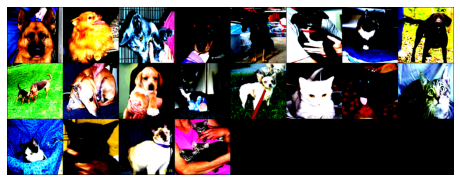

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

for images, labels in train_loader:
    print('images.shape:', images.shape)
    print('labels:', labels)
    plt.figure(figsize=(8,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=8).permute((1, 2, 0)))
    break

#Первое решение
Я написал немного изменённый ResNet и обучал его сначала 6 эпох с шагом обучения 1е-4, потом две эпохи с шагом 1е-5. В итоге получилась точность 0.9485 на тестовом наборе данных.

In [17]:
class SqueezeExcitation(nn.Module):
    def __init__(self, in_channels, reduced_dim):
        super(SqueezeExcitation, self).__init__()
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1), 
            nn.Conv2d(in_channels, reduced_dim, 1),
            nn.SiLU(),
            nn.Conv2d(reduced_dim, in_channels, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return x * self.se(x)

def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet(nn.Module):
    def __init__(self, in_channels=3, num_classes=1):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 32)
        self.conv2 = conv_block(32, 64, pool=True)
        self.res1 = nn.Sequential(conv_block(64, 64), conv_block(64, 64))

        self.transition1 = SqueezeExcitation(64, 32)
        
        self.conv3 = conv_block(64, 256, pool=True)
        self.conv4 = conv_block(256, 256, pool=True)
        self.res2 = nn.Sequential(conv_block(256, 256), conv_block(256, 256))

        self.transition2 = SqueezeExcitation(256, 128)

        self.conv5 = conv_block(256, 512, pool=True)
        self.conv6 = conv_block(512, 512, pool=True)
        self.res3 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))

        self.transition3 = SqueezeExcitation(512, 256)

        self.conv7 = conv_block(512, 1024, pool=True)
        self.conv8 = conv_block(1024, 1024, pool=True)
        self.res4 = nn.Sequential(conv_block(1024, 1024), conv_block(1024, 1024))
        
        self.classifier = nn.Sequential(nn.AdaptiveAvgPool2d((1,1)),
                                        nn.Flatten(),
                                        nn.Linear(1024, num_classes)
                                        )
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out

        out = self.transition1(out)

        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out

        out = self.transition2(out)

        out = self.conv5(out)
        out = self.conv6(out)
        out = self.res3(out) + out

        out = self.transition3(out)

        out = self.conv7(out)
        out = self.conv8(out)
        out = self.res4(out) + out

        out = self.classifier(out)
        return out

In [18]:
model = ResNet()
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(DEVICE)

Для увеличения размера бэтча и размера изображения, а также для ускорения обучения я использовал torch.cuda.amp.autocast()

In [19]:
def train_one_epoch(loader, model, loss_fn, optimizer, scaler):
    loop = tqdm(loader)

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(DEVICE)
        targets = targets.to(DEVICE).unsqueeze(1).float()

        with torch.cuda.amp.autocast():
          scores = model(data)
          loss = loss_fn(scores, targets)

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        loop.set_postfix(loss=loss.item())

In [31]:
model = torch.load("/content/drive/MyDrive/Models/ResNet test_acc = 0,9485")
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(DEVICE)

In [20]:
WEIGHT_DECAY = 1e-4
LEARNING_RATE = 1e-4
NUM_EPOCHS = 6

scaler = torch.cuda.amp.GradScaler()
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(
        model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

In [15]:
check_accuracy(test_loader, model, loss_fn)

Accuracy: 94.85%
0.1726415597756859


tensor(0.9485, device='cuda:0')

In [23]:
gc.collect()
torch.cuda.empty_cache()

In [ ]:
for epoch in range(NUM_EPOCHS):
  train_one_epoch(train_loader, model, loss_fn, optimizer, scaler)
  check_accuracy(test_loader, model, loss_fn)

In [40]:
gc.collect()
torch.cuda.empty_cache()

In [28]:
class Identity(nn.Module):
  def __init__(self):
    super(Identity, self).__init__()
  
  def forward(self, x):
    return x


Затем я решил увеличить точность, заменив классификатор на логистическую регрессию, но точность ухудшилась на 0.04.

In [32]:
model.classifier = Identity()

In [ ]:
X_train, Y_train = get_feature_vectors_for_resnet(model, train_loader, DEVICE)
X_test, Y_test = get_feature_vectors_for_resnet(model, test_loader, DEVICE)

In [53]:
clf1 = LogisticRegression(max_iter=2000)
clf1.fit(X_train, Y_train)

clf2 = LogisticRegression(max_iter=5000)
clf2.fit(X_train, Y_train)

clf3 = LogisticRegression(max_iter=2000, solver="liblinear")
clf3.fit(X_train, Y_train)

clf4 = LogisticRegression(max_iter=5000, solver="liblinear")
clf4.fit(X_train, Y_train)

LogisticRegression(max_iter=5000, solver='liblinear')

In [54]:
test_preds= clf1.predict_proba(X_test)[:,1]
print(f"Accuracy clf1: {clf1.score(X_test, Y_test)}")

test_preds= clf2.predict_proba(X_test)[:,1]
print(f"Accuracy clf2: {clf2.score(X_test, Y_test)}")

test_preds= clf3.predict_proba(X_test)[:,1]
print(f"Accuracy clf3: {clf3.score(X_test, Y_test)}")

test_preds= clf4.predict_proba(X_test)[:,1]
print(f"Accuracy clf4: {clf4.score(X_test, Y_test)}")

Accuracy clf1: 0.945
Accuracy clf2: 0.945
Accuracy clf3: 0.9445
Accuracy clf4: 0.9445


#Второе решение
Второе решение подразумевает дообучение предобученной на ImageNet модели. При таком подходе получилось достичь точность 0.987, а при замене классификатора логистической регрессией - 0.991

In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)
model.fc = nn.Linear(512, 1)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(DEVICE)
model

In [14]:
WEIGHT_DECAY = 1e-4
LEARNING_RATE = 1e-4
NUM_EPOCHS = 1

scaler = torch.cuda.amp.GradScaler()
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(
        model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

In [15]:
for epoch in range(NUM_EPOCHS):
  train_one_epoch(train_loader, model, loss_fn, optimizer, scaler)
  check_accuracy(test_loader, model, loss_fn)

100%|██████████| 400/400 [03:22<00:00,  1.98it/s, loss=0.211]


Accuracy: 98.70%
0.040965332803316414


In [29]:
model.fc = Identity()

In [ ]:
X_train, Y_train = get_feature_vectors_for_resnet34(model, train_loader, DEVICE)
X_test, Y_test = get_feature_vectors_for_resnet34(model, test_loader, DEVICE)

In [ ]:
clf1 = LogisticRegression(max_iter=2000)
clf1.fit(X_train, Y_train)

clf2 = LogisticRegression(max_iter=5000)
clf2.fit(X_train, Y_train)

clf3 = LogisticRegression(max_iter=2000, solver="liblinear")
clf3.fit(X_train, Y_train)

clf4 = LogisticRegression(max_iter=5000, solver="liblinear")
clf4.fit(X_train, Y_train)

In [21]:
test_preds= clf1.predict_proba(X_test)[:,1]
print(f"Accuracy clf1: {clf1.score(X_test, Y_test)}")

test_preds= clf2.predict_proba(X_test)[:,1]
print(f"Accuracy clf2: {clf2.score(X_test, Y_test)}")

test_preds= clf3.predict_proba(X_test)[:,1]
print(f"Accuracy clf3: {clf3.score(X_test, Y_test)}")

test_preds= clf4.predict_proba(X_test)[:,1]
print(f"Accuracy clf4: {clf4.score(X_test, Y_test)}")

Accuracy clf1: 0.991
Accuracy clf2: 0.991
Accuracy clf3: 0.991
Accuracy clf4: 0.991


In [22]:
torch.save(model, "/content/drive/MyDrive/Models/ResNet34 test_acc = 0,991")